<a href="https://colab.research.google.com/github/Long-1234kfgkl/CS114.K21/blob/master/Cuoi_ky_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Upload files dataset đã được crawl từ Drive**

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1OsVIpwbiJl5vf6OtUWBBoot1Ddaa6sR-"})
downloaded.GetContentFile('new_data-1-1000 (1).json')

**Đưa vào các thư viện cần thiết**

In [ ]:
!pip install underthesea

In [ ]:
import pandas as pd
import numpy as np
import re
import underthesea
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

Tiến hành đọc dữ liệu từ file sử dụng thư viện pandas

In [ ]:
dataset = pd.read_json("new_data-1-1000 (1).json", lines = True, encoding = "UTF-8")
dataset.head()

,TYPE,NAME,COMMENT,RATING COMMENT
0,0,iPhone 11 128GB,Sac pin ip11 phần viền kim loại khi đụng vào c...,5
1,-1,iPhone 11 128GB,Mình mua đc 1 tuần mà sao thấy cảm ứng mình lư...,2
2,0,iPhone 11 128GB,Mình mua hôm 20/12 Chụp ngược sáng bị phản chi...,3
3,0,iPhone 11 128GB,"Dùng được 3 ngày, mọi trải nghiệm tuyệt vời, p...",4
4,0,iPhone 11 128GB,Chưa xài lần não hãng này... Nhưng cái 11 này ...,4


In [ ]:
dataset.shape

(3000, 4)

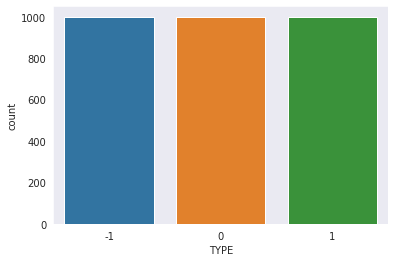

In [ ]:
import seaborn as sns
sns.set_style("dark")
sns.countplot(dataset.TYPE)

In [ ]:
X_data = dataset['COMMENT']
Y_data = dataset['TYPE']

In [ ]:
print(X_data)

0       Sac pin ip11 phần viền kim loại khi đụng vào c...
1       Mình mua đc 1 tuần mà sao thấy cảm ứng mình lư...
2       Mình mua hôm 20/12 Chụp ngược sáng bị phản chi...
3       Dùng được 3 ngày, mọi trải nghiệm tuyệt vời, p...
4       Chưa xài lần não hãng này... Nhưng cái 11 này ...
                              ...                        
2995    mọi thứ đều ổn trừ bạn nhân viên tên Đạt bên T...
2996    mua lại hàng xài rồi nhìn chung cũng tạm được,...
2997    thích hợp để sưu tầm thôi, hoài cỗ nữa nhưng c...
2998    Shop có hỗ trợ đổi trả không admin, mong admin...
2999    Sản phẩm ổn trong tầm giá, không quá cầu kì có...
Name: COMMENT, Length: 3000, dtype: object


**Tiền xử lý dữ liệu, ở đây chúng ta tiến hành các bước như:**


*   Đưa các ký tự về chữ thường
*   Loại bỏ các số
*   Loại bỏ các dấu câu
*   Loại bỏ khoảng trắng thừa
*   Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
*   Tách từ tiếng Việt sử dụng thư viện underthesea có sẵn
*   Loại bỏ các stopwords tiếng Việt sử dụng bộ stopwords có sẵn lấy từ
*   Chuẩn hóa dữ liệu

In [ ]:
#Đưa về kiểu chữ thường
def text_lowercase(text):
    return text.lower()

In [ ]:
#Loại bỏ các con số
def remove_number(text):
    result = re.sub(r'\d+', '', text) 
    return result

In [ ]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
    .replace(";", " ").replace("“", " ") \
    .replace(":", " ").replace("”", " ") \
    .replace('"', " ").replace("'", " ") \
    .replace("!", " ").replace("?", " ") \
    .replace("-", " ").replace("?", " ")  
    return text

In [ ]:
#Loại bỏ khoảng trắng thừa
def remove_whitespace(text): 
    return  " ".join(text.split())

In [ ]:
# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    return text

In [ ]:
#Tách từ tiếng Việt sử dụng thư viện underthesea có sẵn
def VN_Tokenize(text,format='text'):
  return underthesea.word_tokenize(text)

In [ ]:
print(VN_Tokenize("a lô có ai ở đó không?"))

['a', 'lô', 'có', 'ai', 'ở', 'đó', 'không', '?']


In [ ]:
downloaded1 = drive.CreateFile({'id':"1buHsfg9uC70tuUNe852UBCZxcqFg4re5"})
downloaded1.GetContentFile('vietnamese-stopwords-dash (1).txt')

In [ ]:
#Loại bỏ các stopwords tiếng Việt sử dụng bộ stopwords có sẵn lấy từ
def remove_VN_stopwords(text):
    file_stopwords = pd.read_csv("vietnamese-stopwords-dash (1).txt", encoding = 'UTF-8')
    file_stopwords.columns = ["Stop_words"]

    VN_stopword = []
    for i in file_stopwords["Stop_words"]:
        VN_stopword.append(i)
        
    text_token = VN_Tokenize(text)
    result = [word for word in text_token if word not in VN_stopword]
    return " ".join(result)

Chuẩn hóa dữ liệu là bước chuẩn hóa các từ tuy cách viết khác nhau nhưng cùng mang một nghĩa, người dùng có thể đã sử dụng các từ viết tắt, teencode, tiếng Anh,..., việc chuẩn hóa giúp cho bộ dữ liệu trở nên tốt hơn

In [ ]:
#Chuẩn hóa dữ liệu
def Util(text):
    replace_list = {
        'ship': 'vận chuyển', 'shop': 'cửa hàng', 'sho': 'cửa hàng', 'm': 'mình','mk':'mình','mjk':'mình', 'mik': 'mình', 'ko': 'không' , 'k': 'không', 'kh': 'không', 'khong': 'không', 'kg': 'không', 'khg': 'không','hok':'không','hong':'không', 'tl': 'trả lời',
        'rep': 'trả lời', 'r': 'rồi', 'fb': 'facebook', 'face': 'faceook', 'thanks': 'cảm ơn', 'thank': 'cảm ơn', 'tks': 'cảm ơn', 'tk': 'cảm ơn', 'ok': 'tốt', 'oki': 'tốt', 'okie': 'tốt', 'sp': 'sản phẩm',
        'dc': 'được','đc':'được','dk':'được', 'vs': 'với', 'đt': 'điện thoại', 'thjk': 'thích', 'thik': 'thích', 'qá': 'quá', 'trể': 'trễ', 'bgjo': 'bao giờ', 'h': 'giờ', 'qa': 'quá', 'dep': 'đẹp', 'xau': 'xấu', 'ib': 'nhắn tin',
        'cute': 'dễ thương', 'sz': 'size', 'good': 'tốt', 'god': 'tốt', 'bt': 'bình thường','tr':'triệu','dag':'đang','nhiu':'nhiêu','mn':'mọi người','m.n':'mọi người','ac':'anh chị','sag':'sang','s':'sao',
        'sz': 'cỡ', 'size': 'cỡ', 'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được','ae':'anh em','j':'gì','hnay':'hôm nay','lm':'làm','ktra':'kiểm tra','sp':'sản phẩm','zô':'vào',
        'đc': 'được', 'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth ': 'chuẩn chính hãng', 'thick': 'thích','v':'vậy','cng':'cũng','cg':'cũng','ns':'nói','nv':'nhân viên',
        'gud': 'tốt', 'god': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt','ng':'người','chs':'chơi','mng':'mọi người','wa':'quá',
        'sấu': 'xấu', 'gut': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt','trc':'trước',
        'time': 'thời gian', 'qá': 'quá','nc':'nói chung','ace':'anh chị em',
        'product': 'sản phẩm', 'quality': 'chất lượng', 'chat': 'chất' , 'excelent': 'hoàn hảo', 'bad': 'tệ', 'sad': 'tệ',
        'beautiful': 'đẹp', 'tl': 'trả lời', 'r': 'rồi', 'order': 'đặt hàng',
        'chất lg': 'chất lượng', 'sd': 'sử dụng', 'dt': 'điện thoại', 'nt': 'nhắn tin', 'tl': 'trả lời', 'sài': 'xài', 'bjo': 'bao giờ',
        'thik': 'thích', 'sop': 'cửa hàng', 'fb': 'facebook', 'face': 'facebook', 'very': 'rất',
        'dep': 'đẹp', 'xau': 'xấu','tgdđ':'thế giới di động','tgdd':'thế giới di động','đmx':'điện máy xanh',
        'iu': 'yêu', 'fake': 'giả mạo', 'trl': 'trả lời', '><': 'tiêu cực',
        'por': 'tệ', 'poor': 'tệ', 'ib': 'nhắn tin', 'rep': 'trả lời', 'fback': 'feedback', 'fedback': 'feedback',
        'bin': 'pin', 'cx': 'cũng', 'nch': 'nói chuyện', 'ntn': 'như thế nào', 'vde': 'vấn đề'
    }
    text = text.split()
    len_ = len(text)
    for i in range(0, len_):    
      for k, v in replace_list.items():
        if (text[i]==k):
          text[i] = v
    return " ".join(text)

In [ ]:
print(Util("ship hàng tới đây đê"))

vận chuyển hàng tới đây đê


**I. Train data không sử dụng việc chuẩn hóa dữ liệu**

In [ ]:
def Text_PreProcessing_noutil(data):
  result_1 = []
  for i in data:
    i = str(i)
    text = text_lowercase(i)
    text = remove_similarletter(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_VN_stopwords(text)
    result_1.append(text)
  return result_1

In [ ]:
X_data_1 = X_data
Y_data_1 = Y_data

In [ ]:
X_data_1 = Text_PreProcessing_noutil(X_data_1)

In [ ]:
print(X_data_1[0])

sac pin ip viền kim loại đụng cảm giác tê như điện máy lỗi k làm sao khắc phục


TF-IDF (Term Frequency - Inverse Document Frequency):

TF: tần số xuất hiện của 1 từ trong 1 văn bản
IDF: tần số nghịch của 1 từ trong một tập các văn bản
Kỹ thuật TF-IDF dùng để tính toán tần suất xuất hiện của một từ trong văn bản, dựa trên đó để đánh giá mức độ quan trọng của từng từ trong văn bản

Tham khảo: https://codetudau.com/bag-of-words-tf-idf-xu-ly-ngon-ngu-tu-nhien/index.html

TfidfVectorizer dùng để chuyển đổi dữ liệu văn bản sang ma trận các features TF-IDF

Tham khảo: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
vectorizer_1 = TfidfVectorizer()
vectorizer_1.fit(X_data_1)
X_data_tfidf_1 = vectorizer_1.transform(X_data_1).toarray()

In [ ]:
print(vectorizer_1.get_feature_names())

In [ ]:
print(X_data_tfidf_1.shape)

(3000, 3807)


Chia bộ dataset theo tỷ lệ train/test ứng với 80/20

In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_data_tfidf_1, Y_data_1, test_size=0.2)

In [ ]:
model_1 = SVC(kernel='linear')
model_1.fit(X_train_1, Y_train_1)
print("Model SVC")
print("Train score: ", model_1.score(X_train_1, Y_train_1))
print("Test score: ", model_1.score(X_test_1, Y_test_1))

Model SVC
Train score:  0.91
Test score:  0.7183333333333334


In [ ]:
y_pred_1 = model_1.predict(X_test_1)
print("F1 score",f1_score(Y_test_1, y_pred_1, average = 'macro'))

F1 score 0.7200683709980477


Confusion matrix, without normalization
[[152  21  12]
 [ 41 142  50]
 [ 13  32 137]]


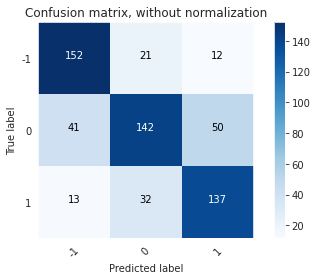

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  
cnf_matrix = confusion_matrix(Y_test_1, y_pred_1, labels=[-1, 0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_1, y_pred_1, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.74      0.82      0.78       185
           0       0.73      0.61      0.66       233
           1       0.69      0.75      0.72       182

   micro avg       0.72      0.72      0.72       600
   macro avg       0.72      0.73      0.72       600
weighted avg       0.72      0.72      0.72       600



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [ ]:
modelnb = MultinomialNB()
modelnb.fit(X_train_1, Y_train_1)
print("Model MultinomialNB")
print("Train score: ", modelnb.score(X_train_1, Y_train_1))
print("Test score: ", modelnb.score(X_test_1, Y_test_1))

Model MultinomialNB
Train score:  0.8391666666666666
Test score:  0.7066666666666667


In [ ]:
y_pred_nb = modelnb.predict(X_test_1)
print("F1 score",f1_score(Y_test_1, y_pred_nb, average = 'macro'))

F1 score 0.7052399956357652


In [ ]:
modellr = LogisticRegression()
modellr.fit(X_train_1, Y_train_1)
print("Model LogisticRegression")
print("Train score: ", modellr.score(X_train_1, Y_train_1))
print("Test score: ", modellr.score(X_test_1, Y_test_1))

Model LogisticRegression
Train score:  0.8575
Test score:  0.7233333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
y_pred_lr = modellr.predict(X_test_1)
print("F1 score",f1_score(Y_test_1, y_pred_lr, average = 'macro'))

F1 score 0.7230434335048761


In [ ]:
modelrdf = RandomForestClassifier(n_estimators=10)
modelrdf.fit(X_train_1, Y_train_1)
print("Model RandomForestClassifier")
print("Train score: ", modelrdf.score(X_train_1, Y_train_1))
print("Test score: ", modelrdf.score(X_test_1, Y_test_1))

Model RandomForestClassifier
Train score:  0.9920833333333333
Test score:  0.625


In [ ]:
y_pred_rdf = modelrdf.predict(X_test_1)
print("F1 score",f1_score(Y_test_1, y_pred_rdf, average = 'macro'))

F1 score 0.625220829712459


**II. Train data sử dụng việc chuẩn hóa dữ liệu**

In [ ]:
def Text_PreProcessing_util(data):
  result_2 = []
  for i in data:
    i = str(i)
    text = text_lowercase(i)
    text=Util(text)
    text = remove_similarletter(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_VN_stopwords(text)
    result_2.append(text)
  return result_2

In [ ]:
X_data_2 = X_data
Y_data_2 = Y_data

In [ ]:
X_data_2 = Text_PreProcessing_util(X_data_2)

In [ ]:
print(X_data_2[0])

sac pin ip viền kim loại đụng cảm giác tê như điện máy lỗi không làm sao khắc phục


In [ ]:
vectorizer_2 = TfidfVectorizer()
vectorizer_2.fit(X_data_2)
X_data_tfidf_2 = vectorizer_2.transform(X_data_2).toarray()

In [ ]:
print(vectorizer_2.get_feature_names())

In [ ]:
print(X_data_tfidf_2.shape)

(3000, 3771)


In [ ]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_data_tfidf_2, Y_data_2, test_size=0.2)

In [ ]:
model_2 = SVC(kernel='linear')
model_2.fit(X_train_2, Y_train_2)
print("Model SVC")
print("Train score: ", model_2.score(X_train_2, Y_train_2))
print("Test score: ", model_2.score(X_test_2, Y_test_2))

Model SVC
Train score:  0.9070833333333334
Test score:  0.735


In [ ]:
y_pred_2 = model_2.predict(X_test_2)
print("F1 score",f1_score(Y_test_2, y_pred_2, average = 'macro'))

F1 score 0.7366300366300366


Confusion matrix, without normalization
[[152  23   8]
 [ 42 141  35]
 [ 13  38 148]]


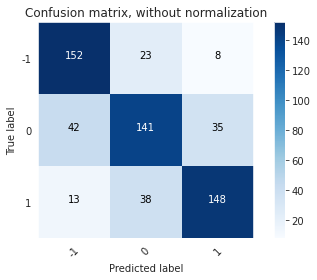

In [ ]:
cnf_matrix_2 = confusion_matrix(Y_test_2, y_pred_2, labels=[-1, 0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_2, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')

In [ ]:
print(classification_report(Y_test_2, y_pred_2, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.73      0.83      0.78       183
           0       0.70      0.65      0.67       218
           1       0.77      0.74      0.76       199

   micro avg       0.73      0.73      0.73       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.73      0.73      0.73       600



In [ ]:
modelnb_2 = MultinomialNB()
modelnb_2.fit(X_train_2, Y_train_2)
print("Model MultinomialNB")
print("Train score: ", modelnb_2.score(X_train_2, Y_train_2))
print("Test score: ", modelnb_2.score(X_test_2, Y_test_2))
y_pred_nb_2 = modelnb_2.predict(X_test_2)
print("F1 score",f1_score(Y_test_2, y_pred_nb_2, average = 'macro'))

Model MultinomialNB
Train score:  0.8445833333333334
Test score:  0.7466666666666667
F1 score 0.7468229516068354


In [ ]:
modellr_2 = LogisticRegression()
modellr_2.fit(X_train_2, Y_train_2)
print("Model LogisticRegression")
print("Train score: ", modellr_2.score(X_train_2, Y_train_2))
print("Test score: ", modellr_2.score(X_test_2, Y_test_2))
y_pred_lr_2 = modellr_2.predict(X_test_2)
print("F1 score",f1_score(Y_test_2, y_pred_lr_2, average = 'macro'))

Model LogisticRegression
Train score:  0.84875
Test score:  0.7533333333333333
F1 score 0.7535765083700388


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
modelrdf_2 = RandomForestClassifier(n_estimators=10)
modelrdf_2.fit(X_train_2, Y_train_2)
print("Model RandomForestClassifier")
print("Train score: ", modelrdf_2.score(X_train_2, Y_train_2))
print("Test score: ", modelrdf_2.score(X_test_2, Y_test_2))
y_pred_rdf_2 = modelrdf_2.predict(X_test_2)
print("F1 score",f1_score(Y_test_2, y_pred_rdf_2, average = 'macro'))

Model RandomForestClassifier
Train score:  0.9920833333333333
Test score:  0.645
F1 score 0.644662555372188


In [ ]:
import joblib
joblib.dump(modellr_2, 'bestmodel.pkl')

['bestmodel.pkl']